# Evoked EPSCs and IPSCs

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
# %load_ext autoreload
# %autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Evoked_PSCs" folder

In [2]:
data_folder = "data/7-Evoked_PSCs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/7-Evoked_PSCs


['data/7-Evoked_PSCs/2025_06_13_0008.abf',
 'data/7-Evoked_PSCs/2025_06_13_0020.abf',
 'data/7-Evoked_PSCs/2025_06_13_0021.abf',
 'data/7-Evoked_PSCs/2025_06_13_0022_100hz.abf',
 'data/7-Evoked_PSCs/2025_06_13_0019.abf',
 'data/7-Evoked_PSCs/2025_06_13_0018.abf',
 'data/7-Evoked_PSCs/2025_06_13_0023_100hz.abf',
 'data/7-Evoked_PSCs/2025_06_13_0016.abf',
 'data/7-Evoked_PSCs/2025_06_13_0017.abf',
 'data/7-Evoked_PSCs/2025_06_13_0015.abf',
 'data/7-Evoked_PSCs/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [19]:
data_file = 'data/7-Evoked_PSCs/2025_06_13_0022_100hz.abf'

Now we can load the file and plot the raw data:

In [36]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

Trace('2025_06_13_0022_100hz.abf')
Number of sweeps: 10
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


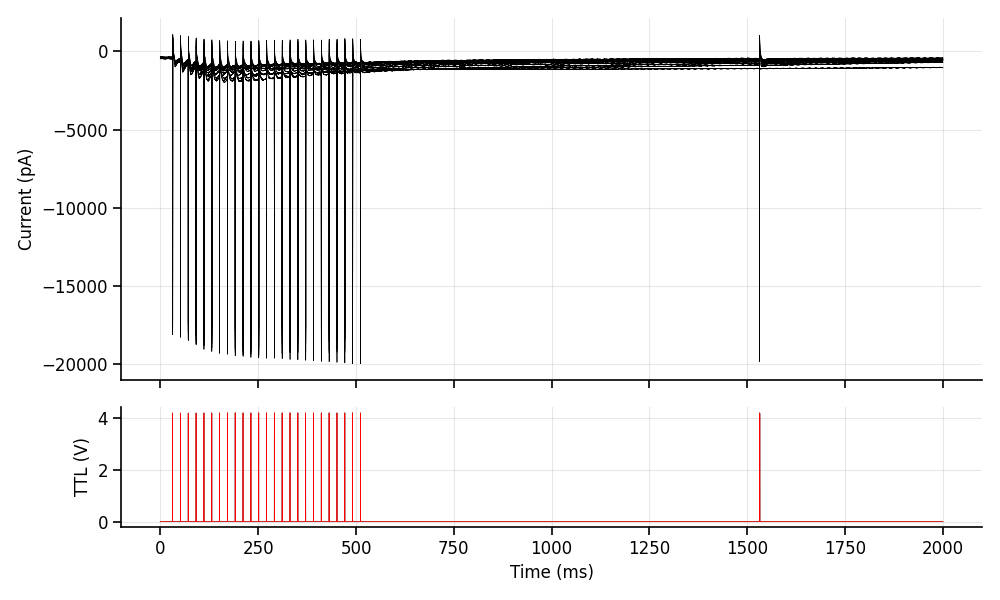

In [37]:
time_units = 'ms'
traces.plot(plot_ttl=True, plot_voltage=False, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [38]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [-382.0007 -465.5518 -461.7188 ... -413.9038 -381.2805 -365.4724]
Baseline voltages: [-1392.6268 -1392.8051 -1392.7294 ... -1392.5438 -1392.6049 -1392.5255]


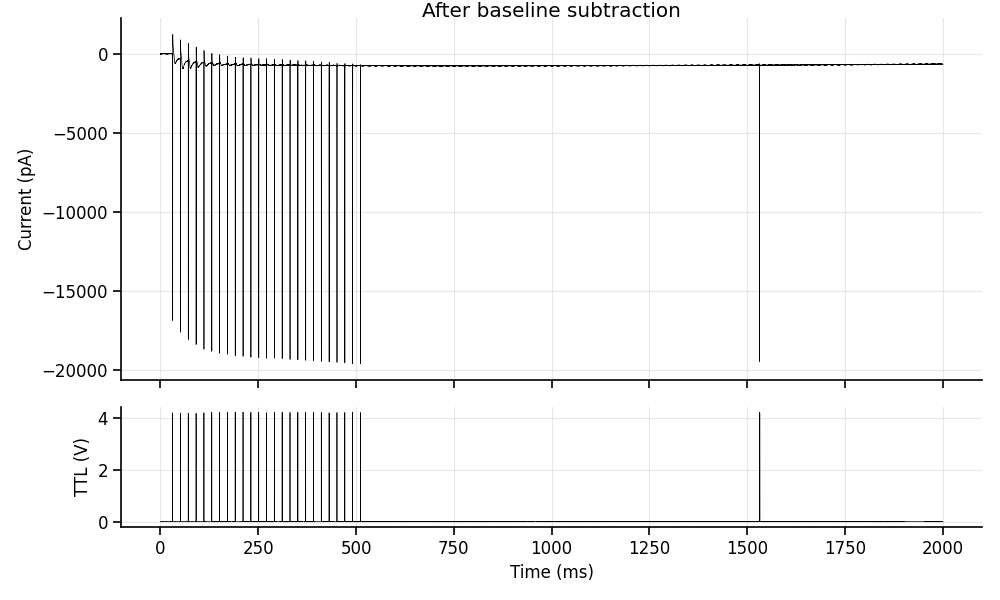

In [39]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 10, 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'all')  # Options: 'current', 'voltage', 'all'
    ax1, ax2 = traces.plot(plot_voltage=False, plot_ttl=True, time_units='ms')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [40]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

In [41]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=1,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.01,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=2000,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.


    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [42]:
if additional_filtering:
    traces=filtered_traces

## 3. Measure EPSCs/IPSCs amplitudes

(If you want to save images, click on the save icon on the left when you hover over the image)

In [43]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=-5000, 
                                    polarity='negative', 
                                    time_units=time_units, 
                                    channel='current', sweep_idx=0)
# traces.get_ttl_events(threshold=0.5, edge='rising', time_units='ms')
print(f"Stim times: {stim_times} ms")

Stim times: [  31.4   51.4   71.4 ...  491.4  511.4 1531.4] ms


Choose a window size around each stim

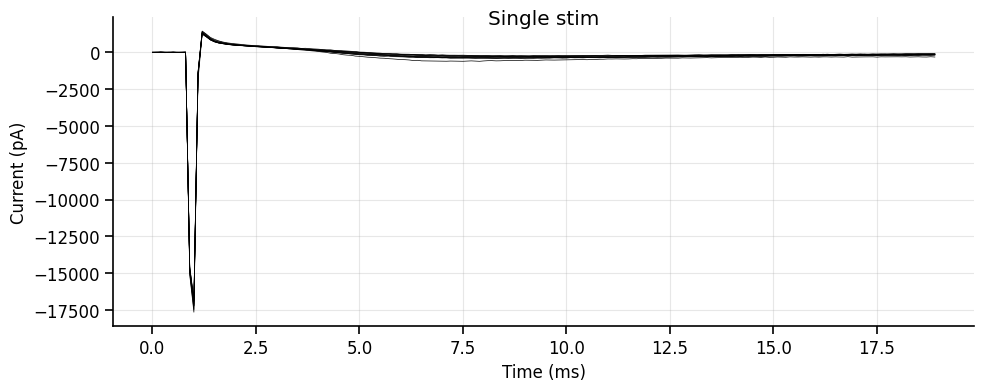

In [66]:
window_size = 19 #ms

stim_time = stim_times[0]
trace_crop = traces.crop(timepoint=stim_time-1, window=window_size, time_units=time_units)
ax = trace_crop.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
ax.set_title('Single stim',y=0.95)
plt.show()  

Measure cumulative currents

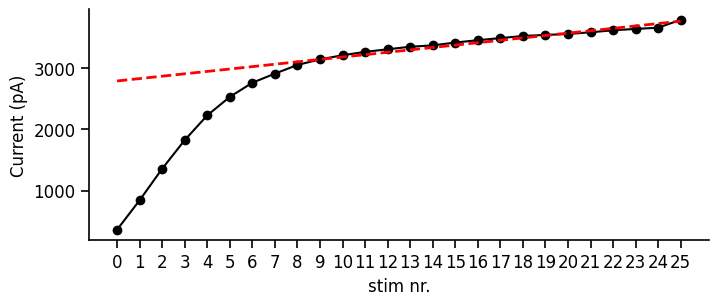

Slope: 39.16, Intercept: 2793.02


In [89]:
abs_currents = []
for i, stim_time in enumerate(stim_times):
    trace_crop = traces.crop(timepoint=stim_time-1, window=window_size, time_units=time_units)
    baseline_all_sweeps = trace_crop.current_data[:,0]
    current_all_sweeps, _ = trace_crop.get_step_measurements(start_time=4, end_time=15, measurement_type='min', time_units='ms')
    current_all_sweeps = current_all_sweeps - baseline_all_sweeps
    abs_current = np.abs(np.mean(current_all_sweeps))
    abs_currents.append(abs_current)   

cumulative_current = np.cumsum(abs_currents)
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = np.arange(len(cumulative_current))
ax.plot(x, cumulative_current, '-o', color='k')
ax.set_xticks(x)
ax.set_ylabel('Current (pA)')
ax.set_xlabel("stim nr.")

# Fit a line to the points
fit_start_point = 7
from scipy.stats import linregress
x_fit = x[fit_start_point:]
current_fit = cumulative_current[fit_start_point:]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, current_fit)
fit_line = slope * x + intercept
ax.plot(x, fit_line, linestyle='--', color='r', label='Fit', linewidth=2)
plt.show()

print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")
